# 状態空間モデル（SARIMAX）でOVを予測する

このノートブックでは `statsmodels` の `SARIMAX`（状態空間モデル・カルマンフィルタ）を使って `OV` を予測します。

- データ: `../data/raw/kadai.xlsx`
- 予測: 末尾500点をテストとして予測し、RMSEとグラフを出力
- オプション: `X1..X83` などを外生変数（exog）として追加可能


In [54]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

# --- パス解決（project root / notebook どちらで実行してもOK）---
CWD = Path.cwd().resolve()
if (CWD / "data" / "raw" / "kadai.xlsx").exists():
    ROOT = CWD
elif (CWD.parent / "data" / "raw" / "kadai.xlsx").exists():
    ROOT = CWD.parent
else:
    raise FileNotFoundError("kadai.xlsx が見つかりません。プロジェクト直下か notebook 配下から実行してください")

DATA_PATH = ROOT / "data" / "raw" / "kadai.xlsx"

# --- データ読み込み ---
df = pd.read_excel(DATA_PATH)
df["process_end_time"] = pd.to_datetime(df["process_end_time"])
df["final_mes_time"] = pd.to_datetime(df["final_mes_time"])

# 時系列として並べる（OVを観測系列にする）
df = df.sort_values("process_end_time").reset_index(drop=True)

y = df["OV"].astype(float)
y.describe()

count    2276.000000
mean      128.035745
std        62.160991
min        25.718750
25%        80.438945
50%       112.385600
75%       168.245275
max       418.405600
Name: OV, dtype: float64

In [55]:
# --- 改善: exog（外生変数）を作る ---
# 重要: OV単体のSARIMAXだと「平均に潰れて一直線」になりやすいので、
# まずは OVのラグ/移動統計を exog に入れるのがおすすめ。
# さらに改善したければ、Xもexogに入れる（ただし相関TOPK選択は学習データだけで = リーク防止）。

USE_LOG_Y = False            # OVのスパイクが強いなら True（学習はlog1p、評価は元スケール）
USE_OV_LAGS_AS_EXOG = True   # ← まずは True 推奨
USE_X_AS_EXOG = True         # Xも入れる（相関TOPK選択は学習データだけで = リーク防止）
TOPK_X = 10                  # Xは少なめの方が安定しやすい（まずは10推奨）
STANDARDIZE_EXOG = True      # exogを標準化して最適化を安定させる
AUTO_DISABLE_X_IF_WORSE = True  # Xを入れてRMSEが悪化するなら自動でXなしに戻す

m = df.copy()

# 時間特徴（トレンド）
USE_TIME_FEATURES = True
if USE_TIME_FEATURES:
    base_time = m["process_end_time"].min()
    m["elapsed_day"] = (m["process_end_time"] - base_time).dt.days.astype(float)

# OV由来のexog（ラグを増やす）
MAX_LAG = 7
ROLL_WINDOWS = [3, 5, 10, 20]

if USE_OV_LAGS_AS_EXOG:
    for k in range(1, MAX_LAG + 1):
        m[f"OV_lag{k}"] = m["OV"].shift(k)
    m["OV_diff1"] = m["OV"].diff(1).shift(1)
    for w in ROLL_WINDOWS:
        m[f"OV_roll_mean{w}"] = m["OV"].rolling(w).mean().shift(1)
        m[f"OV_roll_std{w}"] = m["OV"].rolling(w).std().shift(1)

exog_base_cols: list[str] = []
if USE_TIME_FEATURES:
    exog_base_cols += ["elapsed_day"]

if USE_OV_LAGS_AS_EXOG:
    exog_base_cols += [f"OV_lag{k}" for k in range(1, MAX_LAG + 1)]
    exog_base_cols += ["OV_diff1"]
    exog_base_cols += [f"OV_roll_mean{w}" for w in ROLL_WINDOWS]
    exog_base_cols += [f"OV_roll_std{w}" for w in ROLL_WINDOWS]

x_cols = [f"X{i}" for i in range(1, 84)]

y_all_orig = m["OV"].astype(float)
y_all_model = np.log1p(y_all_orig) if USE_LOG_Y else y_all_orig

len(y_all_orig), len(exog_base_cols), (len(x_cols) if USE_X_AS_EXOG else 0), exog_base_cols[:10]

(2276,
 17,
 83,
 ['elapsed_day',
  'OV_lag1',
  'OV_lag2',
  'OV_lag3',
  'OV_lag4',
  'OV_lag5',
  'OV_lag6',
  'OV_lag7',
  'OV_diff1',
  'OV_roll_mean3'])

In [56]:
# --- 学習/テスト分割（最後の500点をテスト）---
# lag特徴があるので dropna してから分割する

test_size = 500

parts = {
    "OV_orig": y_all_orig,
    "OV_model": y_all_model,
}

if len(exog_base_cols) > 0:
    parts.update({c: m[c].astype(float) for c in exog_base_cols})

if USE_X_AS_EXOG:
    parts.update({c: m[c].astype(float) for c in x_cols})

usable = pd.DataFrame(parts).dropna().reset_index(drop=True)

if len(usable) <= test_size + 10:
    raise ValueError(f"データが少なすぎます: len={len(usable)}")

train_df = usable.iloc[:-test_size].copy()
test_df = usable.iloc[-test_size:].copy()

# y（モデルスケール/元スケール）
y_train = train_df["OV_model"]
y_test = test_df["OV_model"]
y_train_orig = train_df["OV_orig"]
y_test_orig = test_df["OV_orig"]

# exog列確定（OV由来 + （任意）X相関TOPK ※学習データだけで選ぶ）
exog_cols_base = list(exog_base_cols)
exog_cols_full = list(exog_base_cols)
selected_x: list[str] = []

if USE_X_AS_EXOG:
    corr = train_df[x_cols + ["OV_orig"]].corr(numeric_only=True)["OV_orig"].drop("OV_orig")
    selected_x = corr.abs().sort_values(ascending=False).head(TOPK_X).index.tolist()
    exog_cols_full += selected_x
    print("Selected X (TOPK):", selected_x)

exog_train_base = train_df[exog_cols_base] if len(exog_cols_base) > 0 else None
exog_test_base = test_df[exog_cols_base] if len(exog_cols_base) > 0 else None

exog_train_full = train_df[exog_cols_full] if len(exog_cols_full) > 0 else None
exog_test_full = test_df[exog_cols_full] if len(exog_cols_full) > 0 else None

# exog標準化（特にXを入れるときに有効）
if STANDARDIZE_EXOG:
    from sklearn.preprocessing import StandardScaler

    def scale_pair(Xtr, Xte, cols):
        if Xtr is None:
            return None, None
        sc = StandardScaler()
        sc.fit(Xtr)
        # statsmodelsは endog と exog の index の整合をチェックするので、indexを維持する
        Xtr_s = pd.DataFrame(sc.transform(Xtr), columns=cols, index=Xtr.index)
        Xte_s = pd.DataFrame(sc.transform(Xte), columns=cols, index=Xte.index)
        return Xtr_s, Xte_s

    exog_train_base, exog_test_base = scale_pair(exog_train_base, exog_test_base, exog_cols_base)
    exog_train_full, exog_test_full = scale_pair(exog_train_full, exog_test_full, exog_cols_full)

(
    y_train.shape,
    y_test.shape,
    y_train_orig.shape,
    y_test_orig.shape,
    None if exog_train_full is None else exog_train_full.shape,
    exog_cols_full[:10],
)

Selected X (TOPK): ['X33', 'X80', 'X30', 'X50', 'X76', 'X14', 'X11', 'X58', 'X25', 'X1']


((1756,),
 (500,),
 (1756,),
 (500,),
 (1756, 27),
 ['elapsed_day',
  'OV_lag1',
  'OV_lag2',
  'OV_lag3',
  'OV_lag4',
  'OV_lag5',
  'OV_lag6',
  'OV_lag7',
  'OV_diff1',
  'OV_roll_mean3'])

In [57]:
# --- ベースライン（比較用）---
# まずはここより良くなるかを確認（改善してないならモデル設計を見直す）

# Naive: 直前値で予測
rmse_naive = float(np.sqrt(mean_squared_error(y_test_orig, y_test_orig.shift(1).bfill())))

# Mean: 学習平均で固定予測
rmse_mean = float(np.sqrt(mean_squared_error(y_test_orig, np.full(len(y_test_orig), float(y_train_orig.mean())))))

rmse_naive, rmse_mean

(67.36804857762336, 74.60232135584508)

[base] order (2, 0, 2) RMSE 56.21741656848281
[base] order (1, 0, 1) RMSE 56.409665551766125


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[base] order (2, 0, 0) RMSE 154.07712788436703


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[base] order (1, 1, 1) RMSE 259.6362388152525


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[base] order (0, 1, 1) RMSE 129.4660211956109


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[full] order (2, 0, 2) RMSE 78.23538866575898
[full] order (1, 0, 1) RMSE 77.56567898389646


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[full] order (2, 0, 0) RMSE 119.96838793675964


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[full] order (1, 1, 1) RMSE 106.81116112732398
[full] order (0, 1, 1) RMSE 95.4643079734463

Chosen: base (no X)
Best SARIMAX: (2, 0, 2) RMSE: 56.21741656848281
Baseline (naive, mean): 67.36804857762336 74.60232135584508


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


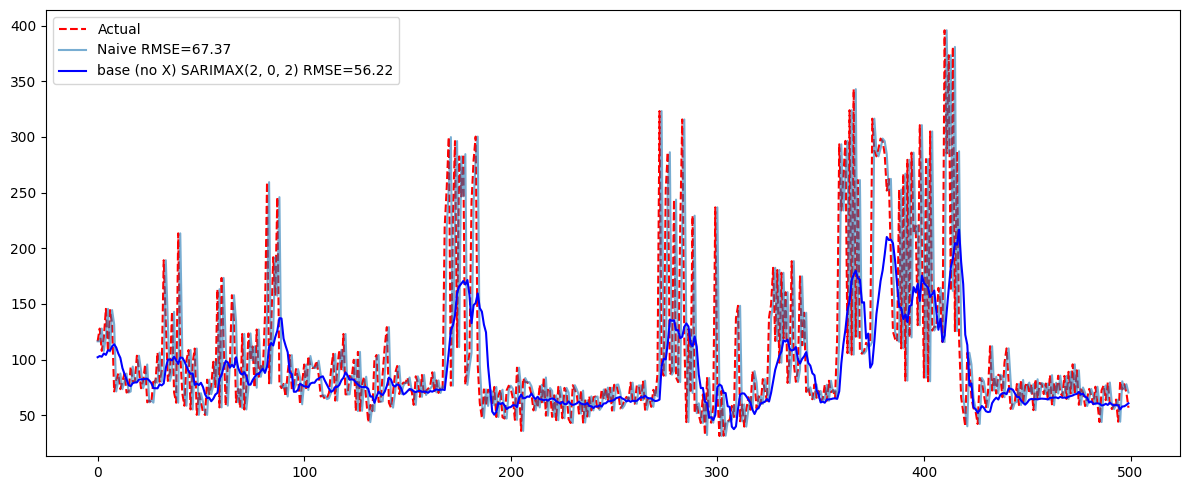

                               SARIMAX Results                                
Dep. Variable:               OV_model   No. Observations:                 1756
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -9028.701
Date:                Tue, 20 Jan 2026   AIC                          18101.402
Time:                        23:49:15   BIC                          18221.721
Sample:                             0   HQIC                         18145.876
                               - 1756                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
elapsed_day       -8.1385      5.381     -1.512      0.130     -18.686       2.409
OV_lag1            3.1420      1.277      2.461      0.014       0.640       5.644
OV_lag2            3.4857      1.207

In [58]:
# --- SARIMAX: orderを軽く探索して一番良いものを採用 ---
# 評価は元スケール（OV_orig）で揃える

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

def inv_y(x):
    return np.expm1(x) if USE_LOG_Y else x

# まずは良さそうな候補を少なめに（計算が重いときはここを削る）
orders = [
    (2, 0, 2),  # ← いま良さそうなら最優先
    (1, 0, 1),
    (2, 0, 0),
    (1, 1, 1),
    (0, 1, 1),
]

best_order = None
best_rmse = float("inf")
best_res = None
best_pred_orig = None

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ValueWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

def fit_best(exog_tr, exog_te, label: str):
    best_order = None
    best_rmse = float("inf")
    best_res = None
    best_pred_orig = None

    for order in orders:
        try:
            model = sm.tsa.SARIMAX(
                y_train,
                exog=exog_tr,
                order=order,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            res = model.fit(disp=False)
            pred_model = res.get_forecast(steps=len(y_test), exog=exog_te).predicted_mean
            pred_orig = inv_y(pred_model)
            rmse = float(np.sqrt(mean_squared_error(y_test_orig, pred_orig)))
            print(label, "order", order, "RMSE", rmse)

            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_res = res
                best_pred_orig = pred_orig
        except Exception as e:
            print(label, "order", order, "failed:", type(e).__name__, str(e)[:120])

    return best_order, best_rmse, best_res, best_pred_orig

# Xなし（OV由来のみ）
base = fit_best(exog_train_base, exog_test_base, label="[base]")

# Xあり（OV由来 + X TOPK）
full = fit_best(exog_train_full, exog_test_full, label="[full]")

(best_order_base, rmse_base, res_base, pred_base) = base
(best_order_full, rmse_full, res_full, pred_full) = full

use_full = USE_X_AS_EXOG
if AUTO_DISABLE_X_IF_WORSE and USE_X_AS_EXOG:
    use_full = rmse_full < rmse_base

if use_full:
    best_order, best_rmse, best_res, best_pred_orig = best_order_full, rmse_full, res_full, pred_full
    used = "full (with X TOPK)"
else:
    best_order, best_rmse, best_res, best_pred_orig = best_order_base, rmse_base, res_base, pred_base
    used = "base (no X)"

print("\nChosen:", used)
print("Best SARIMAX:", best_order, "RMSE:", best_rmse)
print("Baseline (naive, mean):", rmse_naive, rmse_mean)

# --- 可視化 ---
plt.figure(figsize=(12, 5))
plt.plot(y_test_orig.reset_index(drop=True), label="Actual", color="red", linestyle="--")
plt.plot(y_test_orig.shift(1).bfill().reset_index(drop=True), label=f"Naive RMSE={rmse_naive:.2f}", alpha=0.6)
if best_pred_orig is not None:
    plt.plot(pd.Series(best_pred_orig).reset_index(drop=True), label=f"{used} SARIMAX{best_order} RMSE={best_rmse:.2f}", color="blue")
plt.legend()
plt.tight_layout()
plt.show()

# サマリ（必要なときだけ）
if best_res is not None:
    print(best_res.summary())


## LightGBM / XGBoost も同じ条件で比較する

SARIMAXと同じ `train_df / test_df`（末尾500をテスト）・同じ特徴量集合で、LGBM/XGBのRMSEも計算して比較します。

In [59]:
from IPython.display import display

from sklearn.linear_model import LinearRegression

import lightgbm as lgb
from lightgbm import LGBMRegressor

import xgboost as xgb
from xgboost import XGBRegressor

# --- 学習/評価に使う特徴量を決める ---
# いまのSARIMAXセルで選ばれた方に合わせる：
# - used == "base (no X)" なら exog_cols_base
# - used == "full (with X TOPK)" なら exog_cols_full

if used.startswith("full"):
    feature_cols = exog_cols_full
else:
    feature_cols = exog_cols_base

X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

y_train_tab = y_train_orig

y_test_true = y_test_orig

X_train.shape, X_test.shape, len(feature_cols)

((1756, 17), (500, 17), 17)

In [60]:
# --- Tabularモデル（LGBM / XGB） ---
# time-seriesの分割に合わせて、学習データの末尾をevalにしてearly stopping

val_size = min(300, max(50, int(len(X_train) * 0.2)))
X_tr = X_train.iloc[:-val_size]
X_val = X_train.iloc[-val_size:]
y_tr = y_train_tab.iloc[:-val_size]
y_val = y_train_tab.iloc[-val_size:]

# LightGBM
lgbm = LGBMRegressor(
    objective="regression",
    n_estimators=5000,
    learning_rate=0.03,
    num_leaves=31,
    random_state=42,
    force_col_wise=True,
)

lgbm.fit(
    X_tr,
    y_tr,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)],
)

pred_lgb = lgbm.predict(X_test)
pred_lgb_val = lgbm.predict(X_val)
rmse_lgb = float(np.sqrt(mean_squared_error(y_test_true, pred_lgb)))

# XGBoost
xgbr = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=5000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
)

xgbr.fit(
    X_tr,
    y_tr,
    eval_set=[(X_val, y_val)],
    verbose=False,
)

pred_xgb = xgbr.predict(X_test)
pred_xgb_val = xgbr.predict(X_val)
rmse_xgb = float(np.sqrt(mean_squared_error(y_test_true, pred_xgb)))

rmse_lgb, rmse_xgb

[LightGBM] [Info] Total Bins 4109
[LightGBM] [Info] Number of data points in the train set: 1456, number of used features: 17
[LightGBM] [Info] Start training from score 146.609388


(56.21581030109293, 56.53527322386827)

[LightGBM] [Info] Total Bins 4104
[LightGBM] [Info] Number of data points in the train set: 1256, number of used features: 17
[LightGBM] [Info] Start training from score 154.804417


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Total Bins 4097
[LightGBM] [Info] Number of data points in the train set: 1085, number of used features: 17
[LightGBM] [Info] Start training from score 156.093351


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[LightGBM] [Info] Total Bins 4094
[LightGBM] [Info] Number of data points in the train set: 925, number of used features: 17
[LightGBM] [Info] Start training from score 160.213355
walk-forward weights nonneg/sum1 [sarimax, lgbm, xgb]: [0. 1. 0.]
ridge weights (w, intercept): (array([-0.02108472,  1.21974725,  0.09333317]), -46.368637502375805)
opt weights (nonneg/sum1): [0.03224885 0.96775115 0.        ]


,model,rmse
3,Ensemble(mean),55.203183
6,Ensemble(opt_wf),56.155060
1,LGBM,56.215810
4,Ensemble(weighted_wf),56.215810
0,SARIMAX,56.217417
2,XGB,56.535273
5,Ensemble(ridge_wf),60.458899


Best overall: Ensemble(mean)


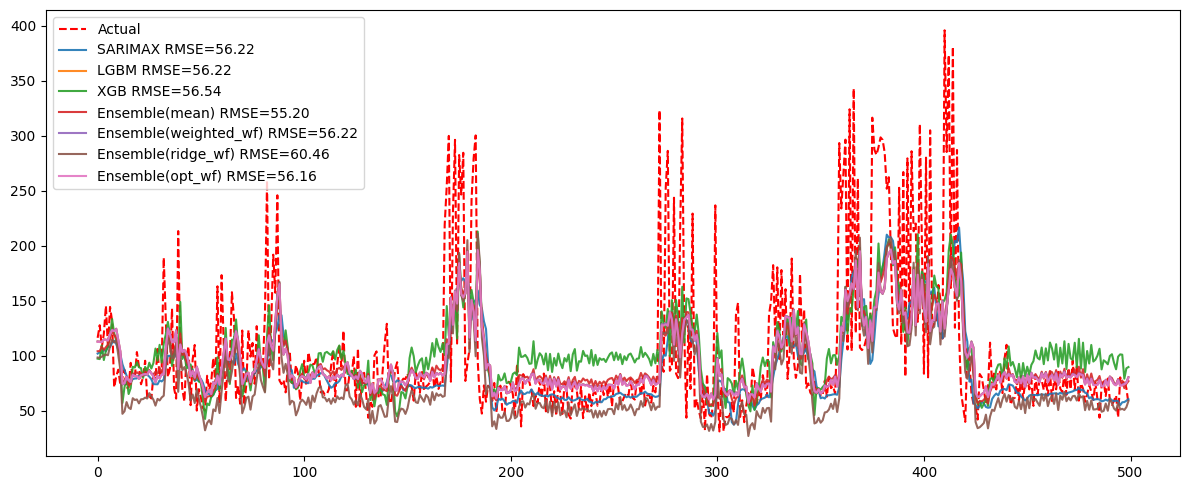

In [61]:
# --- 最終比較と可視化 ---
# SARIMAX / LGBM / XGB を横並びにして比較し、
# さらに「ウォークフォワード（複数区間）で重みを学習する」重み付きアンサンブルを作る。

rmse_sarimax = float(best_rmse)  # これは元スケールRMSE

# 予測（テスト）
pred_sarimax = np.asarray(best_pred_orig) if best_pred_orig is not None else None

# --- アンサンブル（mean）---
pred_ens_mean = None
rmse_ens_mean = None
if pred_sarimax is not None:
    pred_ens_mean = (pred_sarimax + pred_lgb + pred_xgb) / 3.0
    rmse_ens_mean = float(np.sqrt(mean_squared_error(y_test_true, pred_ens_mean)))

# --- アンサンブル（weighted: walk-forwardで重み最適化）---
# trainの末尾を複数区間に分けて、それぞれを「未来」として予測し、
# 予測を縦に積んで重みを学習する（単一valより安定しやすい）。

N_FOLDS = 3
WF_VAL_SIZE = min(val_size, 200)  # 計算が重いなら小さく

# SARIMAX用exog（base/fullどちらを採用したかに合わせる）
if used.startswith("full"):
    sarimax_exog_train = exog_train_full
else:
    sarimax_exog_train = exog_train_base

P_list = []
y_list = []

# walk-forward: trainの末尾から順に複数窓を切り出す
train_len = len(y_train)
for fold in range(N_FOLDS):
    val_end = train_len - fold * WF_VAL_SIZE
    val_start = val_end - WF_VAL_SIZE

    # 学習が短すぎる場合はスキップ
    if val_start < max(300, 5 * WF_VAL_SIZE):
        continue

    # SARIMAX
    sar_y_tr = y_train.iloc[:val_start]
    sar_y_val_orig = y_train_orig.iloc[val_start:val_end]

    sar_ex_tr = sarimax_exog_train.iloc[:val_start] if sarimax_exog_train is not None else None
    sar_ex_val = sarimax_exog_train.iloc[val_start:val_end] if sarimax_exog_train is not None else None

    try:
        sar_model = sm.tsa.SARIMAX(
            sar_y_tr,
            exog=sar_ex_tr,
            order=best_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        sar_res = sar_model.fit(disp=False)
        sar_pred_val_model = sar_res.get_forecast(steps=len(sar_y_val_orig), exog=sar_ex_val).predicted_mean
        sar_pred_val = np.asarray(np.expm1(sar_pred_val_model) if USE_LOG_Y else sar_pred_val_model)
    except Exception as e:
        print("WF SARIMAX failed fold", fold, type(e).__name__, str(e)[:120])
        continue

    # LGBM / XGB（foldのtrainで学習してfoldのvalを予測）
    # 早期打ち切り用に fold train の末尾を内部evalにする
    X_fold = X_train.iloc[:val_start]
    y_fold = y_train_tab.iloc[:val_start]

    inner_val = min(300, max(50, int(len(X_fold) * 0.2)))
    X_tr2 = X_fold.iloc[:-inner_val]
    X_val2 = X_fold.iloc[-inner_val:]
    y_tr2 = y_fold.iloc[:-inner_val]
    y_val2 = y_fold.iloc[-inner_val:]

    X_wf = X_train.iloc[val_start:val_end]

    # LGBM
    lgbm_wf = LGBMRegressor(
        objective="regression",
        n_estimators=5000,
        learning_rate=0.03,
        num_leaves=31,
        random_state=42,
        force_col_wise=True,
    )
    lgbm_wf.fit(
        X_tr2,
        y_tr2,
        eval_set=[(X_val2, y_val2)],
        eval_metric="rmse",
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)],
    )
    pred_lgb_wf = lgbm_wf.predict(X_wf)

    # XGB
    xgb_wf = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=5000,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
    )
    xgb_wf.fit(
        X_tr2,
        y_tr2,
        eval_set=[(X_val2, y_val2)],
        verbose=False,
    )
    pred_xgb_wf = xgb_wf.predict(X_wf)

    P_list.append(np.column_stack([sar_pred_val, pred_lgb_wf, pred_xgb_wf]))
    y_list.append(np.asarray(sar_y_val_orig))

weights_wf = None
pred_ens_wf = None
rmse_ens_wf = None

# 追加: Ridgeスタッキング（負の重み/バイアスを許す）
weights_ridge = None
pred_ens_ridge = None
rmse_ens_ridge = None

# 追加: RMSEを直接最小化（w>=0, sum(w)=1）
weights_opt = None
pred_ens_opt = None
rmse_ens_opt = None

if len(P_list) > 0 and pred_sarimax is not None:
    P_wf = np.vstack(P_list)
    y_wf = np.concatenate(y_list)

    # (A) 非負重み（従来）
    lr = LinearRegression(positive=True, fit_intercept=False)
    lr.fit(P_wf, y_wf)

    w = lr.coef_.astype(float)
    if w.sum() > 0:
        w = w / w.sum()
    else:
        w = np.array([1 / 3, 1 / 3, 1 / 3], dtype=float)

    weights_wf = w
    pred_ens_wf = w[0] * pred_sarimax + w[1] * pred_lgb + w[2] * pred_xgb
    rmse_ens_wf = float(np.sqrt(mean_squared_error(y_test_true, pred_ens_wf)))

    # (B) Ridgeスタッキング（WFデータで学習）
    from sklearn.linear_model import Ridge

    ridge = Ridge(alpha=1.0, fit_intercept=True, random_state=42)
    ridge.fit(P_wf, y_wf)
    w_r = ridge.coef_.astype(float)
    b_r = float(ridge.intercept_)

    weights_ridge = (w_r, b_r)
    pred_ens_ridge = w_r[0] * pred_sarimax + w_r[1] * pred_lgb + w_r[2] * pred_xgb + b_r
    rmse_ens_ridge = float(np.sqrt(mean_squared_error(y_test_true, pred_ens_ridge)))

    # (C) RMSE直接最小化（WFデータで学習）
    from scipy.optimize import minimize

    def rmse_for_w(w_vec):
        y_hat = P_wf @ w_vec
        return float(np.sqrt(np.mean((y_wf - y_hat) ** 2)))

    cons = ({"type": "eq", "fun": lambda w_vec: np.sum(w_vec) - 1.0},)
    bounds = [(0.0, 1.0)] * 3
    x0 = np.array([1 / 3, 1 / 3, 1 / 3], dtype=float)

    res = minimize(rmse_for_w, x0=x0, bounds=bounds, constraints=cons, method="SLSQP")
    if res.success:
        w_o = res.x.astype(float)
        weights_opt = w_o
        pred_ens_opt = w_o[0] * pred_sarimax + w_o[1] * pred_lgb + w_o[2] * pred_xgb
        rmse_ens_opt = float(np.sqrt(mean_squared_error(y_test_true, pred_ens_opt)))

print("walk-forward weights nonneg/sum1 [sarimax, lgbm, xgb]:", weights_wf)
print("ridge weights (w, intercept):", weights_ridge)
print("opt weights (nonneg/sum1):", weights_opt)

summary = pd.DataFrame(
    {
        "model": [
            "SARIMAX",
            "LGBM",
            "XGB",
            "Ensemble(mean)",
            "Ensemble(weighted_wf)",
            "Ensemble(ridge_wf)",
            "Ensemble(opt_wf)",
        ],
        "rmse": [
            rmse_sarimax,
            rmse_lgb,
            rmse_xgb,
            rmse_ens_mean,
            rmse_ens_wf,
            rmse_ens_ridge,
            rmse_ens_opt,
        ],
    }
).sort_values("rmse")

display(summary)

best_name = summary.iloc[0]["model"]
print("Best overall:", best_name)

plt.figure(figsize=(12, 5))
plt.plot(y_test_true.reset_index(drop=True), label="Actual", color="red", linestyle="--")
if pred_sarimax is not None:
    plt.plot(pd.Series(pred_sarimax).reset_index(drop=True), label=f"SARIMAX RMSE={rmse_sarimax:.2f}", alpha=0.9)
plt.plot(pd.Series(pred_lgb).reset_index(drop=True), label=f"LGBM RMSE={rmse_lgb:.2f}", alpha=0.9)
plt.plot(pd.Series(pred_xgb).reset_index(drop=True), label=f"XGB RMSE={rmse_xgb:.2f}", alpha=0.9)
if pred_ens_mean is not None:
    plt.plot(pd.Series(pred_ens_mean).reset_index(drop=True), label=f"Ensemble(mean) RMSE={rmse_ens_mean:.2f}", alpha=0.9)
if pred_ens_wf is not None:
    plt.plot(pd.Series(pred_ens_wf).reset_index(drop=True), label=f"Ensemble(weighted_wf) RMSE={rmse_ens_wf:.2f}", alpha=0.9)
if pred_ens_ridge is not None:
    plt.plot(pd.Series(pred_ens_ridge).reset_index(drop=True), label=f"Ensemble(ridge_wf) RMSE={rmse_ens_ridge:.2f}", alpha=0.9)
if pred_ens_opt is not None:
    plt.plot(pd.Series(pred_ens_opt).reset_index(drop=True), label=f"Ensemble(opt_wf) RMSE={rmse_ens_opt:.2f}", alpha=0.9)
plt.legend()
plt.tight_layout()
plt.show()

## 次の一手（精度改善）

- `order=(p,d,q)` を複数試してRMSEが良いものを選ぶ
- `USE_EXOG=True` にして外生変数（`X1..X83`）を投入する（ただし過学習に注意）
- ラグ特徴（例：`OV_lag1` など）をexogとして追加して「状態空間 + 追加特徴」で精度を上げる
